# Import Libraries
---

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision import models

from datasets import load_dataset
import torchvision.transforms as transforms

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load Hugging Face MNIST
ds = load_dataset("ylecun/mnist")

# Convert to PyTorch tensors
def hf_to_torch(dataset):
    images = torch.tensor(np.array(dataset["image"])).float().div(255.0).unsqueeze(1)  # shape (N, 1, 28, 28)
    labels = torch.tensor(dataset["label"])
    return TensorDataset(images, labels)

train_dataset = hf_to_torch(ds["train"])
test_dataset = hf_to_torch(ds["test"])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 60000, Test samples: 10000


# 1. Data Analysis
---

In [ ]:
# 1. Number of classes
train_labels = ds["train"]["label"]
num_classes = len(np.unique(train_labels))
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 10


In [ ]:
# 2. Class Distribution and Imbalance Check
class_counts = np.bincount(train_labels)
class_labels = np.arange(num_classes)

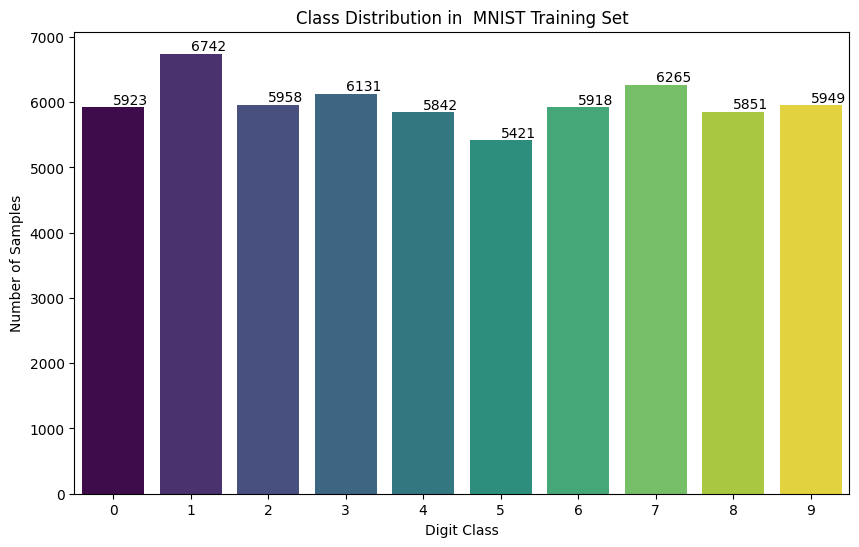

In [ ]:
# 3. Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts, hue=class_labels, palette="viridis", legend=False)
plt.title("Class Distribution in  MNIST Training Set")
plt.xlabel("Digit Class")
plt.ylabel("Number of Samples")
plt.xticks(class_labels)
for i, v in enumerate(class_counts):
    plt.text(i, v, str(v), color='black', va="bottom")
plt.savefig("class_distribution.png")
plt.show()

# sns.barplot(x=class_labels, y=class_counts, hue=class_labels, palette="viridis", legend=False)


In [ ]:
# Check for imbalance (basic threshold: variation > 10% of mean)
mean_samples = np.mean(class_counts)
std_samples = np.std(class_counts)
imbalance_threshold = mean_samples * 0.1
is_imbalanced = std_samples > imbalance_threshold
print(f"Mean samples per class: {mean_samples:.0f}")
print(f"Standard deviation of samples: {std_samples:.0f}")
print(f"Imbalance threshold (10% of mean): {imbalance_threshold:.0f}")
print(f"Is the dataset imbalanced? {'Yes' if is_imbalanced else 'No'}")

Mean samples per class: 6000
Standard deviation of samples: 322
Imbalance threshold (10% of mean): 600
Is the dataset imbalanced? No


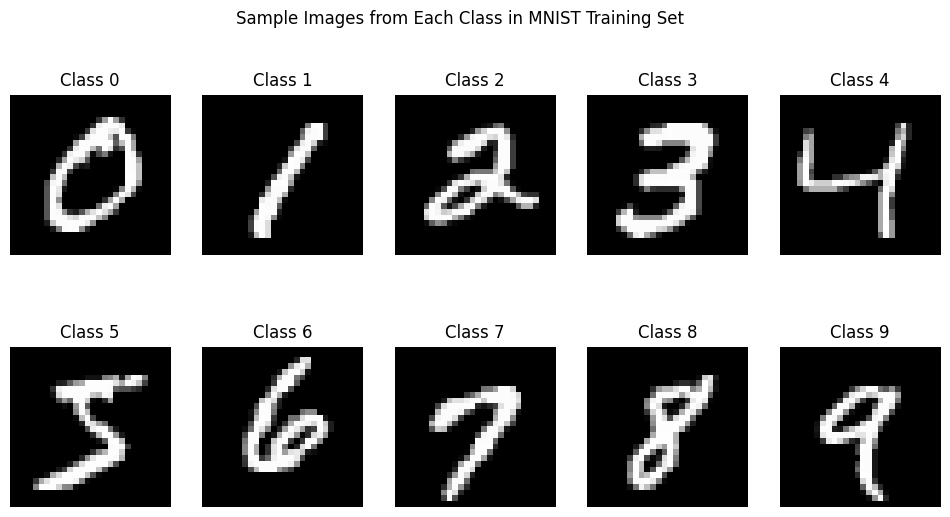

In [ ]:
# 3. Data Visualization - Sample Images
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    # Find indices of images for this class
    class_indices = np.where(np.array(train_labels) == i)[0]
    sample_idx = class_indices[0]  # Take the first image of this class
    image = ds["train"]["image"][sample_idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Class {i}")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class in MNIST Training Set")
plt.savefig("sample_images.png")
plt.show()

# 2. Initial Clustering on Raw training Image
---

Initial clustering completed.


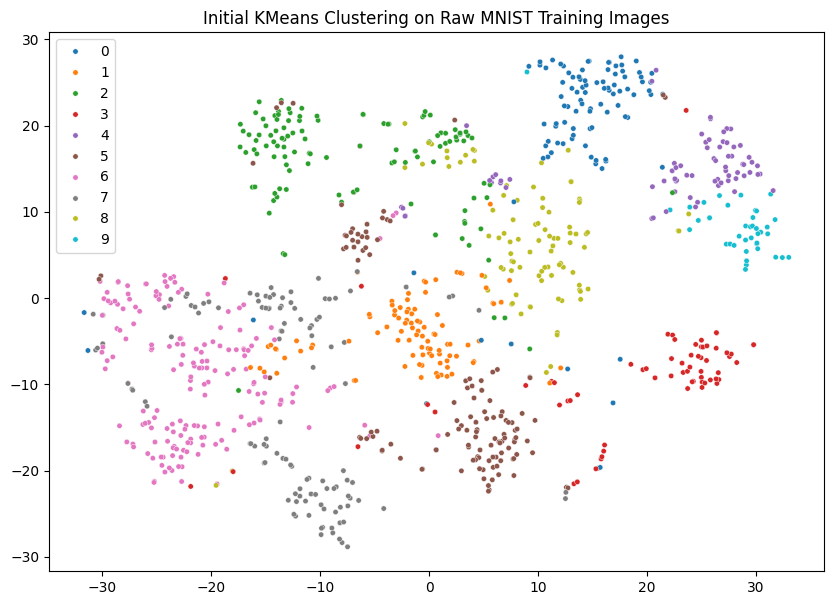

Visualization completed. Plot saved as 'initial_clustering_raw.png'.


In [ ]:
# Initial clustering on raw training images (before any model training)
raw_train_images = torch.tensor(np.array(ds["train"]["image"])).float().div(255.0)  # (N, 28, 28)
raw_train_images_flat = raw_train_images.view(-1, 28*28).numpy()  # (N, 784)
kmeans_init = KMeans(n_clusters=10, n_init=20, random_state=42)
initial_kmeans_labels = kmeans_init.fit_predict(raw_train_images_flat)

print("Initial clustering completed.")

# Visualizing initial clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500)  # Updated n_iter to max_iter
raw_images_2d = tsne.fit_transform(raw_train_images_flat[:1000])  # Subsample for visualization

plt.figure(figsize=(10, 7))
sns.scatterplot(x=raw_images_2d[:, 0], y=raw_images_2d[:, 1], hue=initial_kmeans_labels[:1000], palette='tab10', s=15)
plt.title("Initial KMeans Clustering on Raw MNIST Training Images")
plt.savefig('initial_clustering_raw.png')  # Save the plot
plt.show()  # Ensure the plot is displayed
plt.close()

print("Visualization completed. Plot saved as 'initial_clustering_raw.png'.")

# 3. Model Definition
---

In [ ]:
import torch.nn.functional as F

def preprocess_for_resnet(batch):
    batch = F.interpolate(batch, size=(224, 224), mode='bilinear', align_corners=False)
    batch = batch.repeat(1, 3, 1, 1)  # Convert 1 channel to 3
    return batch

In [ ]:
#Get one batch
images, labels = next(iter(train_loader))

# Original Image Size
print("Original batch shape:", images.shape)

# After preprocessing for ResNet
inputs = preprocess_for_resnet(images)
print("After preprocess_for_resnet:", inputs.shape)

Original batch shape: torch.Size([128, 1, 28, 28])
After preprocess_for_resnet: torch.Size([128, 3, 224, 224])


In [ ]:
class ResNetAutoencoder(nn.Module):
    def __init__(self, base_model="resnet50", pretrained=True):
        super().__init__()
        # 1) Load any torchvision ResNet and strip off avgpool+fc
        backbone = getattr(models, base_model)(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])

        # 2) Figure out how many channels it actually outputs
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            feat = self.encoder(dummy)
        feat_dim = feat.shape[1]      # ← e.g. 512 for resnet18, 2048 for resnet50
        self._feat_dim = feat_dim     # store if you want later

        # 3) Build a decoder that mirrors that depth
        #    We'll upsample from (feat_dim x 7 x 7) → (1 x 28 x 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(feat_dim, feat_dim // 2, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # → (feat_dim/2 x 14 x 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(feat_dim // 2, feat_dim // 4, kernel_size=3,
                               stride=2, padding=1, output_padding=1),  # → (feat_dim/4 x 28 x 28)
            nn.ReLU(True),
            # Optional extra refinement
            nn.Conv2d(feat_dim // 4, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            # Final to single-channel
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = z.mean(dim=[2,3])
        recon = self.decoder(z)
        return recon, z_flat


# 4. Pretrain Autoencoder
---

In [ ]:
model = ResNetAutoencoder(base_model="resnet50").to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Encoder output channels:", model._feat_dim)

Encoder output channels: 2048


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # ——— Training ———
    model.train()
    running_train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)

        outputs, _ = model(inputs)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)

    # ——— Validation ———
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            inputs = preprocess_for_resnet(images)

            outputs, _ = model(inputs)
            loss = criterion(outputs, images)

            running_val_loss += loss.item() * images.size(0)

    avg_val_loss = running_val_loss / len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss:   {avg_val_loss:.4f}")


Epoch [1/10]  Train Loss: 0.1123  Val Loss:   0.1140
Epoch [2/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [3/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [4/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [5/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [6/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [7/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [8/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [9/10]  Train Loss: 0.1120  Val Loss:   0.1140
Epoch [10/10]  Train Loss: 0.1120  Val Loss:   0.1140


# 5. Define ASRNet Model & Loss Functions
---

In [ ]:
class DEC(nn.Module):
    def __init__(self, autoencoder, n_clusters=10, latent_dim=64):
        super(DEC, self).__init__()
        self.autoencoder = autoencoder
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, x):
        _, z = self.autoencoder(x)
        q = self.soft_assign(z)
        return z, q

    def soft_assign(self, z):
        dist = torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2)
        q = 1.0 / (1.0 + dist)
        q = q ** ((1 + 1) / 2)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

def kl_divergence(p, q):
    return torch.sum(p * torch.log((p + 1e-6) / (q + 1e-6)), dim=1).mean()


# 6. Initialize ASRNetwith KMeans
---

In [ ]:
# 1) Freeze decoder
for p in model.decoder.parameters():
    p.requires_grad = False

# 2) Gather latents (with proper preprocessing!)
model.eval()
latent_list = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)    # ← resize & 3-channel
        _, z = model(inputs)                      # model now returns (recon, z)
        latent_list.append(z.cpu())

latent_features = torch.cat(latent_list, dim=0).numpy()


# KMeans init
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
kmeans.fit(latent_features)

# ASRNetmodel
dec_model = DEC(model, n_clusters=10, latent_dim=latent_features.shape[1]).to(device)
dec_model.cluster_centers.data.copy_(
    torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
)



tensor([[0.2961, 0.5646, 0.4492,  ..., 0.4145, 0.5777, 0.3500],
        [0.3012, 0.4297, 0.4174,  ..., 0.2783, 0.3853, 0.2594],
        [0.3300, 0.4746, 0.4482,  ..., 0.3253, 0.4539, 0.2966],
        ...,
        [0.2933, 0.4939, 0.4464,  ..., 0.3467, 0.4851, 0.3062],
        [0.3604, 0.5971, 0.3918,  ..., 0.3513, 0.4592, 0.3621],
        [0.3569, 0.5467, 0.4632,  ..., 0.3817, 0.5302, 0.3417]],
       device='cuda:0')

# 7. Fine-Tune Using Clustering Loss
---

In [ ]:
dec_optimizer = optim.Adam(dec_model.parameters(), lr=1e-3)
num_dec_epochs = 10

for epoch in range(num_dec_epochs):
    # ——— Training Phase ———
    dec_model.train()
    train_kl = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)

        # Forward + target
        z, q = dec_model(inputs)
        p = target_distribution(q.detach())

        # KL loss + backward
        loss = kl_divergence(p, q)
        dec_optimizer.zero_grad()
        loss.backward()
        dec_optimizer.step()

        train_kl += loss.item() * images.size(0)

    avg_train_kl = train_kl / len(train_loader.dataset)

    # ——— Validation Phase ———
    dec_model.eval()
    val_kl = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            inputs = preprocess_for_resnet(images)

            z, q = dec_model(inputs)
            p = target_distribution(q)

            loss = kl_divergence(p, q)
            val_kl += loss.item() * images.size(0)

    avg_val_kl = val_kl / len(test_loader.dataset)

    print(f"ASRNetEpoch [{epoch+1}/{num_dec_epochs}]  "
          f"Train KL: {avg_train_kl:.6f}  "
          f"Val KL:   {avg_val_kl:.6f}")
dec_val_kl = avg_val_kl


DEC Epoch [1/10]  Train KL: 0.200234  Val KL:   0.200618
DEC Epoch [2/10]  Train KL: 0.152100  Val KL:   0.101702
DEC Epoch [3/10]  Train KL: 0.120737  Val KL:   0.092815
DEC Epoch [4/10]  Train KL: 0.115163  Val KL:   0.083877
DEC Epoch [5/10]  Train KL: 0.088894  Val KL:   0.090644
DEC Epoch [6/10]  Train KL: 0.084659  Val KL:   0.035606
DEC Epoch [7/10]  Train KL: 0.080771  Val KL:   0.071670
DEC Epoch [8/10]  Train KL: 0.074407  Val KL:   0.066413
DEC Epoch [9/10]  Train KL: 0.064668  Val KL:   0.045556
DEC Epoch [10/10]  Train KL: 0.060429  Val KL:   0.062690


# 7.1 Model Parameters count
---

# ResNet Autoencoder model summary
---

In [ ]:
summary(model, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
ResNetAutoencoder                             [1, 1, 28, 28]            --
├─Sequential: 1-1                             [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

# Proposed model
---

In [ ]:
summary(dec_model, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                             Output Shape              Param #
DEC                                                [1, 2048]                 20,480
├─ResNetAutoencoder: 1-1                           [1, 1, 28, 28]            --
│    └─Sequential: 2-1                             [1, 2048, 7, 7]           --
│    │    └─Conv2d: 3-1                            [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 256, 56, 56]          215,808
│    │    └─Sequential: 3-6                        [1, 512, 28, 28]          1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 14, 14]         7,098,368
│    │    └─Sequential: 3-8                        [1, 2048, 7, 7]           14,964,736


# 8. Evaluate Clustering with Metrics
---

In [ ]:
dec_model.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)
        _, z = dec_model.autoencoder(inputs)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

all_latents = np.vstack(all_latents)
all_labels = np.hstack(all_labels)

kmeans_final = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(all_latents)

# Metrics
sil_score = silhouette_score(all_latents, cluster_labels)
db_score = davies_bouldin_score(all_latents, cluster_labels)
ch_score = calinski_harabasz_score(all_latents, cluster_labels)

print(f"Silhouette Score:        {sil_score:.4f}")
print(f"Davies-Bouldin Index:    {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")
print(f"{'KL:'} {dec_val_kl:.4f}")


Silhouette Score:        0.8891
Davies-Bouldin Index:    0.2332
Calinski-Harabasz Index: 268396.2812
KL: 0.0627


# 9. Visualize Clusters with t-SNE
---

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


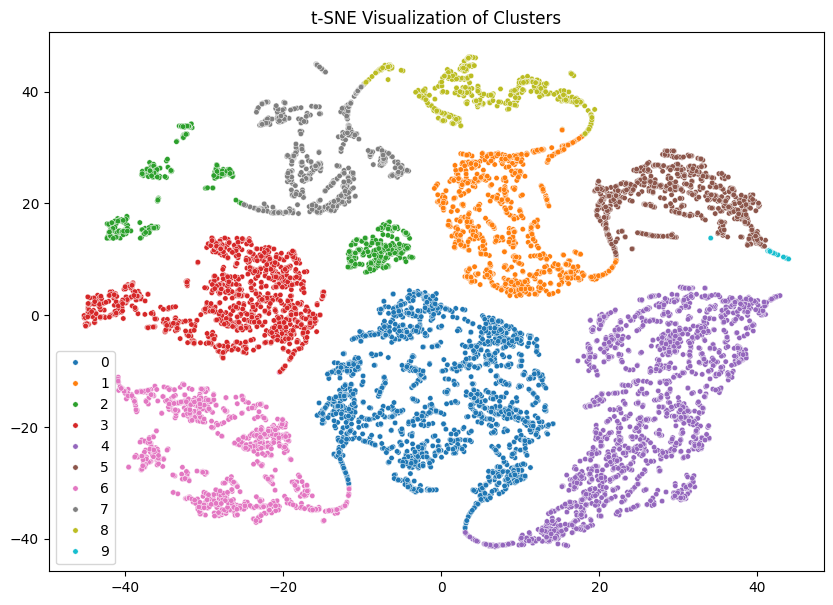

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
latents_2d = tsne.fit_transform(all_latents)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=cluster_labels, palette='tab10', legend='full', s=15)
plt.title("t-SNE Visualization of Clusters")
plt.show()


# 10. SOM Implemenetation
---

In [ ]:
class SOM:
    def __init__(self, map_size, input_dim, learning_rate=0.5, sigma=None):
        self.map_size = map_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(map_size) / 2
        # Initialize weights randomly
        self.weights = torch.randn(map_size[0], map_size[1], input_dim).to(device)
        self.weights = self.weights / torch.norm(self.weights, dim=2, keepdim=True)
        # Grid coordinates
        x, y = torch.meshgrid(torch.arange(map_size[0]), torch.arange(map_size[1]), indexing='ij')
        self.grid = torch.stack([x, y], dim=-1).float().to(device)

    def get_bmu(self, x):

        dists = torch.cdist(x.unsqueeze(1), self.weights.view(-1, self.input_dim)).squeeze(1)
        bmu_indices = dists.argmin(dim=1)
        bmu_coords = torch.stack([bmu_indices // self.map_size[1], bmu_indices % self.map_size[1]], dim=1)
        return bmu_coords

    def update(self, x, t, max_iter):

        lr = self.learning_rate * np.exp(-t / max_iter)
        sigma_t = self.sigma * np.exp(-t / max_iter)
        bmu_coords = self.get_bmu(x)  # (batch_size, 2)

        for i in range(x.shape[0]):
            dist_to_bmu = torch.norm(self.grid - bmu_coords[i].float(), dim=2)
            influence = torch.exp(-dist_to_bmu**2 / (2 * sigma_t**2))
            delta = lr * influence.unsqueeze(-1) * (x[i] - self.weights)
            self.weights += delta

    def predict(self, x):
        dists = torch.cdist(x.unsqueeze(1), self.weights.view(-1, self.input_dim)).squeeze(1)
        bmu_indices = dists.argmin(dim=1)
        return bmu_indices.cpu().numpy()


# 11. Extract latent features
---

In [ ]:
model.eval()
latent_features = []
test_latents = []
test_labels = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)
        _, z = model(inputs)
        latent_features.append(z.cpu().numpy())
    for images, labels in test_loader:
        images = images.to(device)
        inputs = preprocess_for_resnet(images)
        _, z = model(inputs)
        test_latents.append(z.cpu().numpy())
        test_labels.append(labels.numpy())

latent_features = np.vstack(latent_features)
test_latents = np.vstack(test_latents)
test_labels = np.hstack(test_labels)

latent_dim = latent_features.shape[1]

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


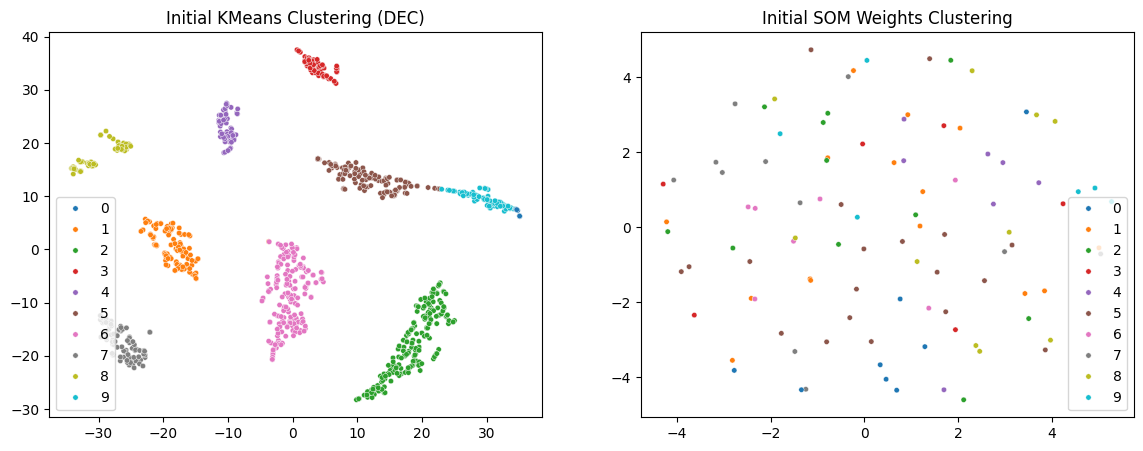

In [ ]:
# Initial KMeans clustering (for DEC)
kmeans_init = KMeans(n_clusters=10, n_init=20, random_state=42)
initial_kmeans_labels = kmeans_init.fit_predict(latent_features)

# Initial SOM clustering
som = SOM(map_size=(10, 10), input_dim=latent_dim)
initial_som_weights = som.weights.view(-1, latent_dim).cpu().numpy()
kmeans_som_init = KMeans(n_clusters=10, random_state=42)
initial_som_labels = kmeans_som_init.fit_predict(initial_som_weights)

# Visualize initial clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
latents_2d = gestirets_2d = tsne.fit_transform(latent_features[:1000])  # Subsample for visualization
som_weights_2d = tsne.fit_transform(initial_som_weights)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=initial_kmeans_labels[:1000], palette='tab10', s=15)
plt.title("Initial KMeans Clustering (DEC)")
plt.subplot(1, 2, 2)
sns.scatterplot(x=som_weights_2d[:, 0], y=som_weights_2d[:, 1], hue=initial_som_labels, palette='tab10', s=15)
plt.title("Initial SOM Weights Clustering")
plt.savefig('initial SOM clustering.png')
plt.show()
plt.close()

# 12. Train SOM
---

In [ ]:
som = SOM(map_size=(2, 5), input_dim=latent_dim)
max_iter = 1000
latent_tensor = torch.tensor(latent_features, dtype=torch.float32).to(device)
for t in range(max_iter):
    indices = np.random.permutation(latent_features.shape[0])[:128]
    batch = latent_tensor[indices]
    som.update(batch, t, max_iter)
    if (t + 1) % 100 == 0:
        print(f"SOM Iteration [{t+1}/{max_iter}]")

SOM Iteration [100/1000]
SOM Iteration [200/1000]
SOM Iteration [300/1000]
SOM Iteration [400/1000]
SOM Iteration [500/1000]
SOM Iteration [600/1000]
SOM Iteration [700/1000]
SOM Iteration [800/1000]
SOM Iteration [900/1000]
SOM Iteration [1000/1000]


In [ ]:
latent_tensor = torch.tensor(test_latents, dtype=torch.float32).to(device)

# quantization error)
with torch.no_grad():
    dists = torch.cdist(latent_tensor, som.weights.view(-1, som.input_dim))
    bmu_dists, _ = dists.min(dim=1)
quant_error_som = bmu_dists.mean().item()


In [ ]:
def som_detailed_summary(som):
    # Compute sizes
    rows, cols = som.map_size
    n_neurons = rows * cols
    w_shape = som.weights.shape          # (rows, cols, input_dim)
    g_shape = som.grid.shape             # (n_neurons, 2)
    # Parameter counts
    total_weights = som.weights.numel()
    total_grid_elems = som.grid.numel()

    print("Self-Organizing Map (SOM) Summary")
    print("="*40)
    print(f"Map size:        {som.map_size}   (total neurons: {n_neurons})")
    print(f"Input dim:       {som.input_dim}")
    print(f"Learning rate:   {som.learning_rate}")
    print(f"Sigma (radius):  {som.sigma}")
    print()
    print("Structure:")
    print(f"  ├─ weights (Parameter)    shape={tuple(w_shape)}    params={total_weights}")
    print(f"  └─ grid    (Buffer)       shape={tuple(g_shape)}    elems={total_grid_elems}")
    print()
    print("Parameter counts:")
    print(f"  Total params:           {total_weights + total_grid_elems}")
    print(f"  Trainable params:       {total_weights}")
    print(f"  Non-trainable params:   {total_grid_elems}")

# Example usage:
som = SOM(map_size=(2,5), input_dim=latent_dim, learning_rate=0.5)
som_detailed_summary(som)


Self-Organizing Map (SOM) Summary
Map size:        (2, 5)   (total neurons: 10)
Input dim:       2048
Learning rate:   0.5
Sigma (radius):  2.5

Structure:
  ├─ weights (Parameter)    shape=(2, 5, 2048)    params=20480
  └─ grid    (Buffer)       shape=(2, 5, 2)    elems=20

Parameter counts:
  Total params:           20500
  Trainable params:       20480
  Non-trainable params:   20


# 13. Evaluate SOM
---

In [ ]:
som_labels = som.predict(torch.tensor(test_latents, dtype=torch.float32).to(device))
sil_score_som = silhouette_score(test_latents, som_labels)
db_score_som = davies_bouldin_score(test_latents, som_labels)
ch_score_som = calinski_harabasz_score(test_latents, som_labels)

print("\nSOM Clustering Metrics:")
print(f"Silhouette Score:        {sil_score_som:.4f}")
print(f"Davies-Bouldin Index:    {db_score_som:.4f}")
print(f"Calinski-Harabasz Index: {ch_score_som:.4f}")
print(f"{'Quantization Error:':<25}{quant_error_som:.4f}")


SOM Clustering Metrics:
Silhouette Score:        0.4777
Davies-Bouldin Index:    0.7270
Calinski-Harabasz Index: 7089.3218
Quantization Error:      5.2572


# 14. Visualize SOM clustering
---

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


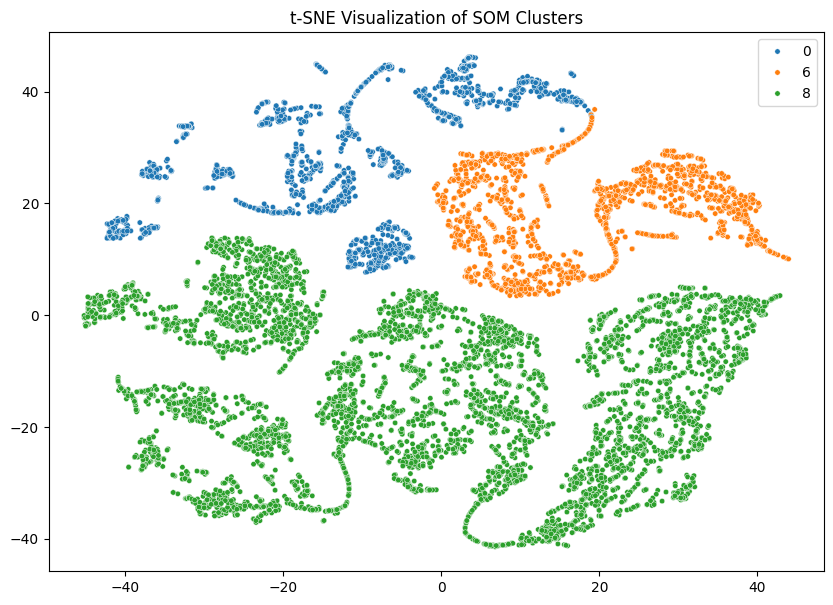

In [ ]:
test_latents_2d = tsne.fit_transform(test_latents)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=test_latents_2d[:, 0], y=test_latents_2d[:, 1], hue=som_labels, palette='tab10', s=15)
plt.title("t-SNE Visualization of SOM Clusters")
plt.show()
plt.savefig('som_clustering.png')
plt.close()

# 15. Comparing metric results of Proposed model and SOM
---

In [ ]:
print("\nComparison Table:")
print(f"{'Metric':<35} {'ASRNet':<10} {'SOM':<10}")
print(f"{'Silhouette Score':<35} {sil_score:.4f}    {sil_score_som:.4f}")
print(f"{'Davies-Bouldin Index':<35} {db_score:.4f}    {db_score_som:.4f}")
print(f"{'Calinski-Harabasz Index':<35} {ch_score:.4f}    {ch_score_som:.4f}")
print(f"{'Final KL / Quantization Error':<35} {dec_val_kl:.4f}    {quant_error_som:.4f}")



Comparison Table:
Metric                              DEC        SOM       
Silhouette Score                    0.8891    0.4777
Davies-Bouldin Index                0.2332    0.7270
Calinski-Harabasz Index             268396.2812    7089.3218
Final KL / Quantization Error       0.0627    5.2572
